In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np


In [2]:
#dataset preparation
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))
            ])
mnist = datasets.MNIST(root='data', download=True, transform=transform)
#batch_size
batch_size=64
dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True, drop_last=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
MODEL_NAME = 'MNIST_GAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("MODEL_NAME = {}, DEVICE = {}".format(MODEL_NAME, DEVICE))

MODEL_NAME = MNIST_GAN, DEVICE = cuda


Model Definition

In [4]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.make_mnist = nn.Sequential(
        nn.Linear(100, 256),
        nn.LeakyReLU(0.2, inplace=False),
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2, inplace=False),
        nn.Linear(512, 1024),
        nn.Linear(1024, 28*28),
        nn.Tanh()
    )
  def forward(self, inputs):
    return self.make_mnist(inputs).view(-1,1,28,28)

In [5]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.division = nn.Sequential(
        nn.Linear(28*28,1024),
        nn.LeakyReLU(0.2, inplace=False),
        nn.Dropout(inplace=True),
        nn.Linear(1024,512),
        nn.LeakyReLU(0.2, inplace=False),
        nn.Dropout(inplace=True),
        nn.Linear(512,256),
        nn.LeakyReLU(0.2, inplace=False),
        nn.Dropout(inplace=True),
        nn.Linear(256,1),
        nn.Sigmoid()
    )
  def forward(self, inputs):
    inputs = inputs.view(-1,28*28)
    return self.division(inputs)

In [6]:
G=Generator().to(DEVICE)
D=Discriminator().to(DEVICE)

In [7]:
# utility function to measure time
import time
import math

def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s/60)
  s -= m*60
  return '%dm %ds'%(m,s)

In [8]:
criterion = nn.BCELoss()
G_optim = Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optim = Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [9]:
D_losses=[]
G_losses=[]

In [10]:
max_epoch = 5
step = 0 
plot_every = 200

total_D_loss = 0
total_G_loss = 0

start = time.time()

for epoch in range(max_epoch):
  for real_data, _ in dataloader:
    target_real = torch.ones(batch_size, 1)
    target_fake = torch.zeros(batch_size, 1)
    x, y_real, y_fake = real_data.to(DEVICE), target_real.to(DEVICE), target_fake.to(DEVICE)
    
    ###I. Discriminator training###
    D_result_from_real = D(x) # real image
    D_loss_real = criterion(D_result_from_real, y_real) 

    z=torch.randn((batch_size, 100))
    x_fake = z.to(DEVICE)

    fake_data = G(x_fake) #make fake image
    D_result_from_fake = D(fake_data) 
    D_loss_fake = criterion(D_result_from_fake,y_fake)

    D_loss = D_loss_real + D_loss_fake # sum of losses
    total_D_loss += D_loss.item()

    D.zero_grad()
    D_loss.backward()
    D_optim.step()
    

    ###II. Generator training###
    z=torch.randn((batch_size, 100))
    x_fake=z.to(DEVICE)

    fake_data = G(x_fake) #make fake image
    D_result_from_fake=D(fake_data)
    G_loss = criterion(D_result_from_fake, y_real)
    total_G_loss += G_loss.item()

    G.zero_grad()
    G_loss.backward()
    G_optim.step()

    if step % 500 == 0 :
      print('Epoch ({}): {}/{}, Step: {}, G_Loss: {}, D_Loss: {}'.format(timeSince(start), epoch, max_epoch, step, G_loss.item(), D_loss.item()))
    if (step + 1) % plot_every == 0:
      D_losses.append(total_D_loss / plot_every)
      total_D_loss = 0
      G_losses.append(total_G_loss / plot_every)
      total_G_loss = 0

    step+=1

Epoch (0m 0s): 0/5, Step: 0, G_Loss: 0.7285494804382324, D_Loss: 1.3852168321609497
Epoch (0m 9s): 0/5, Step: 500, G_Loss: 2.872100353240967, D_Loss: 0.8480494022369385
Epoch (0m 18s): 1/5, Step: 1000, G_Loss: 1.6061975955963135, D_Loss: 0.8519427180290222
Epoch (0m 27s): 1/5, Step: 1500, G_Loss: 2.248671054840088, D_Loss: 0.5038647651672363
Epoch (0m 36s): 2/5, Step: 2000, G_Loss: 1.1877474784851074, D_Loss: 0.6410022974014282
Epoch (0m 45s): 2/5, Step: 2500, G_Loss: 2.534698963165283, D_Loss: 0.803525447845459
Epoch (0m 54s): 3/5, Step: 3000, G_Loss: 1.3015421628952026, D_Loss: 0.7084063291549683
Epoch (1m 3s): 3/5, Step: 3500, G_Loss: 1.7203788757324219, D_Loss: 0.6801335215568542
Epoch (1m 12s): 4/5, Step: 4000, G_Loss: 1.2379257678985596, D_Loss: 0.6431012153625488
Epoch (1m 21s): 4/5, Step: 4500, G_Loss: 1.1949076652526855, D_Loss: 0.8621646165847778


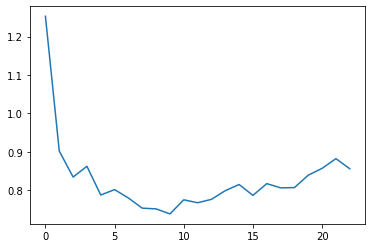

In [11]:
import matplotlib.pyplot as plt
#D_losses
plt.figure()
plt.plot(D_losses)

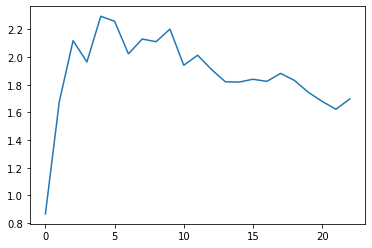

In [12]:
#G_losses
plt.figure()
plt.plot(G_losses)

In [13]:
#sample images
z = torch.randn((5*5),100)
z = z.to(DEVICE)
Generated_image = G(z)
image_numpy=Generated_image.view(25, 28, 28).cpu().data.numpy()

def show_images(image,s=5):
  print(image.shape)
  fig=plt.figure(figsize=(5, 5))
  columns = s
  rows = s
  for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(image[i-1],cmap='gray')
  plt.show()



(25, 28, 28)


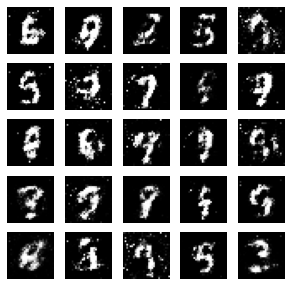

In [14]:
show_images(image_numpy)